# IACR 2025
# **NLP Workshop hands-on session: WHO Performance Status Classification**

Irene Cara, PhD candidate at IKNL and Amsterdam UMC <br>
i.cara@iknl.nl

<br>

Dimitris Katsimpokis, Sr. Data Scientist at IKNL <br>
d.katsimpokis@iknl.nl


<br>
<br>
<br>



https://github.com/IKNL/iacr_2025_llm_workshop/

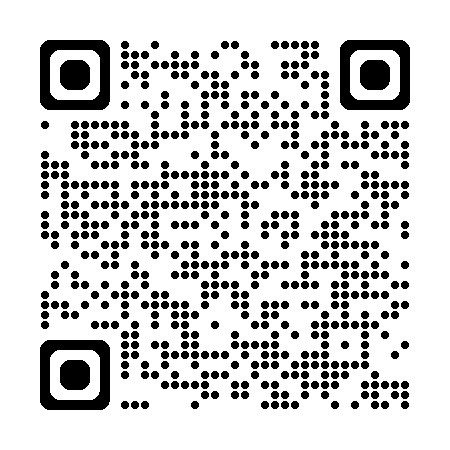


---
Text classification is a fundamental task in NLP that involves assigning predefined categories or labels to text documents.
<br>
<br>
In a cancer registry, this could be applied for:


*   Detecting if a clinical notes contains specific information (e.g. morphology of cancer description) --> selection of relevant notes
*   Assign a label to a clinical note or part of the text (e.g. text with description of morphology, assign ICD-O-3 code)


<br>

In the hands-on session today, we will focus on the task of classifying the WHO Performance Status in clinical progress reports.

<br>
<br>
<br>



----
##Background

**WHO Performance Status (PS)** is a standard measure of patient functional status and ability to carry out daily activities:
<br>
<br>

| PS | Description |
|----|-------------|
| 0  | Fully active, able to carry out all activities without restriction |
| 1  | Restricted in physically strenuous activity but ambulatory and able to carry out light work|
| 2  | Ambulatory and capable of all self-care but unable to carry out work activities; up and about more than 50% of waking hours |
| 3  | Capable of limited self-care, confined to bed/chair >50% of the day but not bedridden|
| 4  | Completely disabled, cannot carry out any self-care; totally bedbound |
| 5  | Deceased |

<br>
<br>
<br>




---

## Why NLP for Performance Status?


PS is not always annotated in a structured/tabular format or with a score. e.g. Missing rates are higher than 30% depending on cancer in NCR.

<br>

Clinical notes contain this information in **unstructured text**, e.g., "patient walks independently," "bedbound, needs full care."

<br>

PS is highly predictive of survival.

<br>


- Clinical notes are unstructured; manual extraction is time-consuming.
- **NLP automates classification** of text into PS categories.
- Use cases: filling in registries, clinical trials, patient monitoring, EHR analytics.

<br>
<br>
<br>



---

## Overview of Methods

1. **TF-IDF + Classifier**
   - Converts text into sparse vectors based on word importance.
   - Pros: interpretable, simple.
   - Cons: ignores context.

2. **Sentence transformers embeddings + Classifier**
   - Dense vectors capturing semantic meaning.
   - Pros: captures context and similarity in meaning.
   - Cons: pre-traned LLM used to extract embeddings might not be suitable to capture important information from medical language.

3. **Few-shot Sentence transformers**
   - Dense vectors capturing semantic meaning.
   - Quick finetuning/training makes pre-trained models aware of specific task (e.g. PS classification)
   - Pros: works well even when only few labelled examples are available.
   - Cons: GPU is needed, but less computational expensive than full training.
  

4. **Prompt-based zero-shot Classification**
   - Uses pre-trained language models (e.g. GPT) to classify without task-specific training.
   - Flexible, works with few or no labeled examples, but depends on **prompt quality**.
   - Pros: no labelled examples are needed.
   - Cons: pre-trained models do not usually know medical language, less precise.
   

<br>
<br>
<br>



---

## Workshop Objectives

By the end of this session, you will:

1. Explore clinical text describing the performance status of patients.
2. See how **TF-IDF** and **sentence embeddings** classify text into WHO PS.
3. Try zero-shot and few-shot classification with pre-trained models.
4. Experiment with **prompt engineering** to improve zero-shot predictions.
5. Understand strengths, limitations, and practical considerations of NLP in clinical data.


<br>
<br>
<br>


To run cells, press on the play icon on the upperleft of each cell 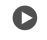 or press ALT+Enter.

In [1]:
# @title
def predict_tfidf(text_list):
    X_new = tfidf.transform(text_list)
    return clf_tfidf.predict(X_new)

def conf_matrix_plot(y_test, y_pred_tfidf,name_model,ticks=[-1,0,1,2,3,4]):
  cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
  sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
  plt.xlabel("Predicted PS")
  plt.ylabel("True PS")
  plt.title(name_model + " Confusion Matrix")
  plt.show()
  return

def print_most_frequent(tfidf,X,n=10):
  # Get the average TF-IDF score for each term across all documents
  feature_names = tfidf.get_feature_names_out()
  average_tfidf_scores = X.mean(axis=0).A1

  # Create a pandas Series for easy sorting
  tfidf_series = pd.Series(average_tfidf_scores, index=feature_names)

  # Sort the terms by their average TF-IDF scores
  sorted_tfidf = tfidf_series.sort_values(ascending=False)

  # Print the most frequent terms (highest TF-IDF)
  print("Most frequent terms (highest average TF-IDF):")
  print(sorted_tfidf.head(n)) # Display top 10

  return


def load_data(more_files=False):
  url='https://github.com/IKNL/iacr_2025_llm_workshop/raw/refs/heads/main/data/IACR_PS_workshop.csv'
  df=pd.read_csv(url)
  #df=pd.read_csv('/content/IACR_PS_workshop.csv')



  return df

def load_models():
  # Unzipping a file using the unzip command
  if os.path.exists('/content/Model_IACR_rs9')==False:
    !wget https://github.com/IKNL/iacr_2025_llm_workshop/raw/refs/heads/main/model/Model_IACR_rs9.zip
    !unzip /content/Model_IACR_rs9.zip
  return

def predict_sent_embed(text_list):
  X_new = embed_model.encode(text_list)
  return clf_embed.predict(X_new)


def test_sentence(sentence):
  y_pred_tfidf = predict_tfidf([sentence])
  print('The predicted PS for the TF-IDF classifier is:' + str(y_pred_tfidf[0]))
  pred_embed=predict_sent_embed([sentence])
  print('The predicted PS for the sentence embeddings classifier is:' + str(pred_embed[0]))
  pred_few_shot=model.predict([sentence])
  print('The predicted PS for the setfit few shot classifier is:' + str(pred_few_shot[0]))
  pred_zero_shot=predict_zero_shot(sentence)
  print('The predicted PS for the prompt-based zero shot classifier is:' + str(pred_zero_shot[0]))
  return

def measure_performance(y_test, y_pred_tfidf):
  conf_matrix_plot(y_test, y_pred_tfidf,"TF-IDF",[0,1,2,3,4,5])
  accuracy_tfidf = accuracy_score(y_test.values, y_pred_tfidf)

  print("Accuracy is: " + str(accuracy_tfidf))

  return accuracy_tfidf

def get_counts(tf_idf_vectorizer,df_train,sentence):
  counts=[]
  for word in tfidf_vectorizer.get_feature_names_out(): #[(tfidf_vectorizer.transform([sentence]).toarray()!=0)[0]]:
    print(word)
    count=0
    for doc in df_train.values:
      if re.search(r"\b" + re.escape(word) + r"[\W]*\b", doc, re.IGNORECASE):
        count+=1
    counts.append(count)
  return counts

def idf_scores(counts,n_docs,norm=True):
  scores=pd.DataFrame(data=[(np.log((n_docs+1)/(count+1)) + 1) for count in counts]).T
  if norm:
    scores=scores/sum(scores.iloc[0]**2)**0.5
  return scores

def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def print_accuracies(models,accuracy_scores):
    x = np.arange(len(models))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x, accuracy_scores, width, label='Accuracy') # Modified to use x instead of x - width/2

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    autolabel(ax,rects1)

    fig.tight_layout()
    plt.show()

def predict_zero_shot(text):
    result = zero_shot(text, candidate_labels)
    return result['labels'][0], result['scores'][0]


In [2]:
# =========================================
# NLP Workshop
# WHO Performance Status Classification
# =========================================

# ------------------------------
# Module 0: Install Dependencies
# ------------------------------
!pip install setfit

# ------------------------------
# Module 1: Load packages and dataset
# ------------------------------
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import sentence_transformers
import transformers
from setfit import SetFitModel, SetFitTrainer, Trainer, TrainingArguments, sample_dataset, get_templated_dataset
from datasets import Dataset
import matplotlib.pyplot as plt
import re
import logging
import warnings

#Allow logging of Transformers and Sentence Transformers only when needed
transformers.logging.set_verbosity(transformers.logging.CRITICAL)
logging.getLogger('sentence_transformers').setLevel(logging.CRITICAL)

# Suppress all warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00


# **Module 0: Data loading and train-test split**

We will load a dataset containing **274** synthetic clinical notes, containing descriptive information of the status of the patient and adverse events. Each note is labelled with the corresponding PS (in real life this process is called annotation, and must be done by experts in the field, e.g. medical doctors).

<br>

Example taken from dataset:
<br>
*A 33-year-old female diagnosed with gastric carcinoma, currently at stage II, presents for ongoing assessment. The patient is mostly bedridden or chairbound and requires significant assistance with personal care. The patient has undergone surgical intervention with moderate response observed. Recent laboratory investigations revealed Hemoglobin 11.8 g/dL, WBC 9.0 x10^³/µL, Platelets 163 x10^³/µL, Creatinine 1.4 mg/dL, AST 37 U/L, ALT 37 U/L, Sodium 144 mmol/L, Potassium 4.5 mmol/L. Recent imaging via biopsy showed progressive lesions. On examination, the patient appeared clinically stable, with vital signs within acceptable limits. The patient experienced palpitations during treatment. The patient experienced dysphagia during treatment. The plan includes follow-up imaging, optimization of systemic therapy, and supportive measures as needed.*

<br>

PS Label: **3**

PS snippet: The patient is mostly bedridden or chairbound and requires significant assistance with personal care.

In order to measure the performance of the different classification models, we will divide this dataset into:

<br>

* Train set: the dataset we will use for fitting/training the model
* Test set: the dataset we will use to test the performance of the model trained on the train set, and therefore compare the true labels (real PS of each document) with the predicted labels.

<br>

We will show the accuracy of the models, which is the number of correct predicted PS out of the total number of documents, and the confusion matrix, which shows how many labels are predicted for each class vs the real label classes.

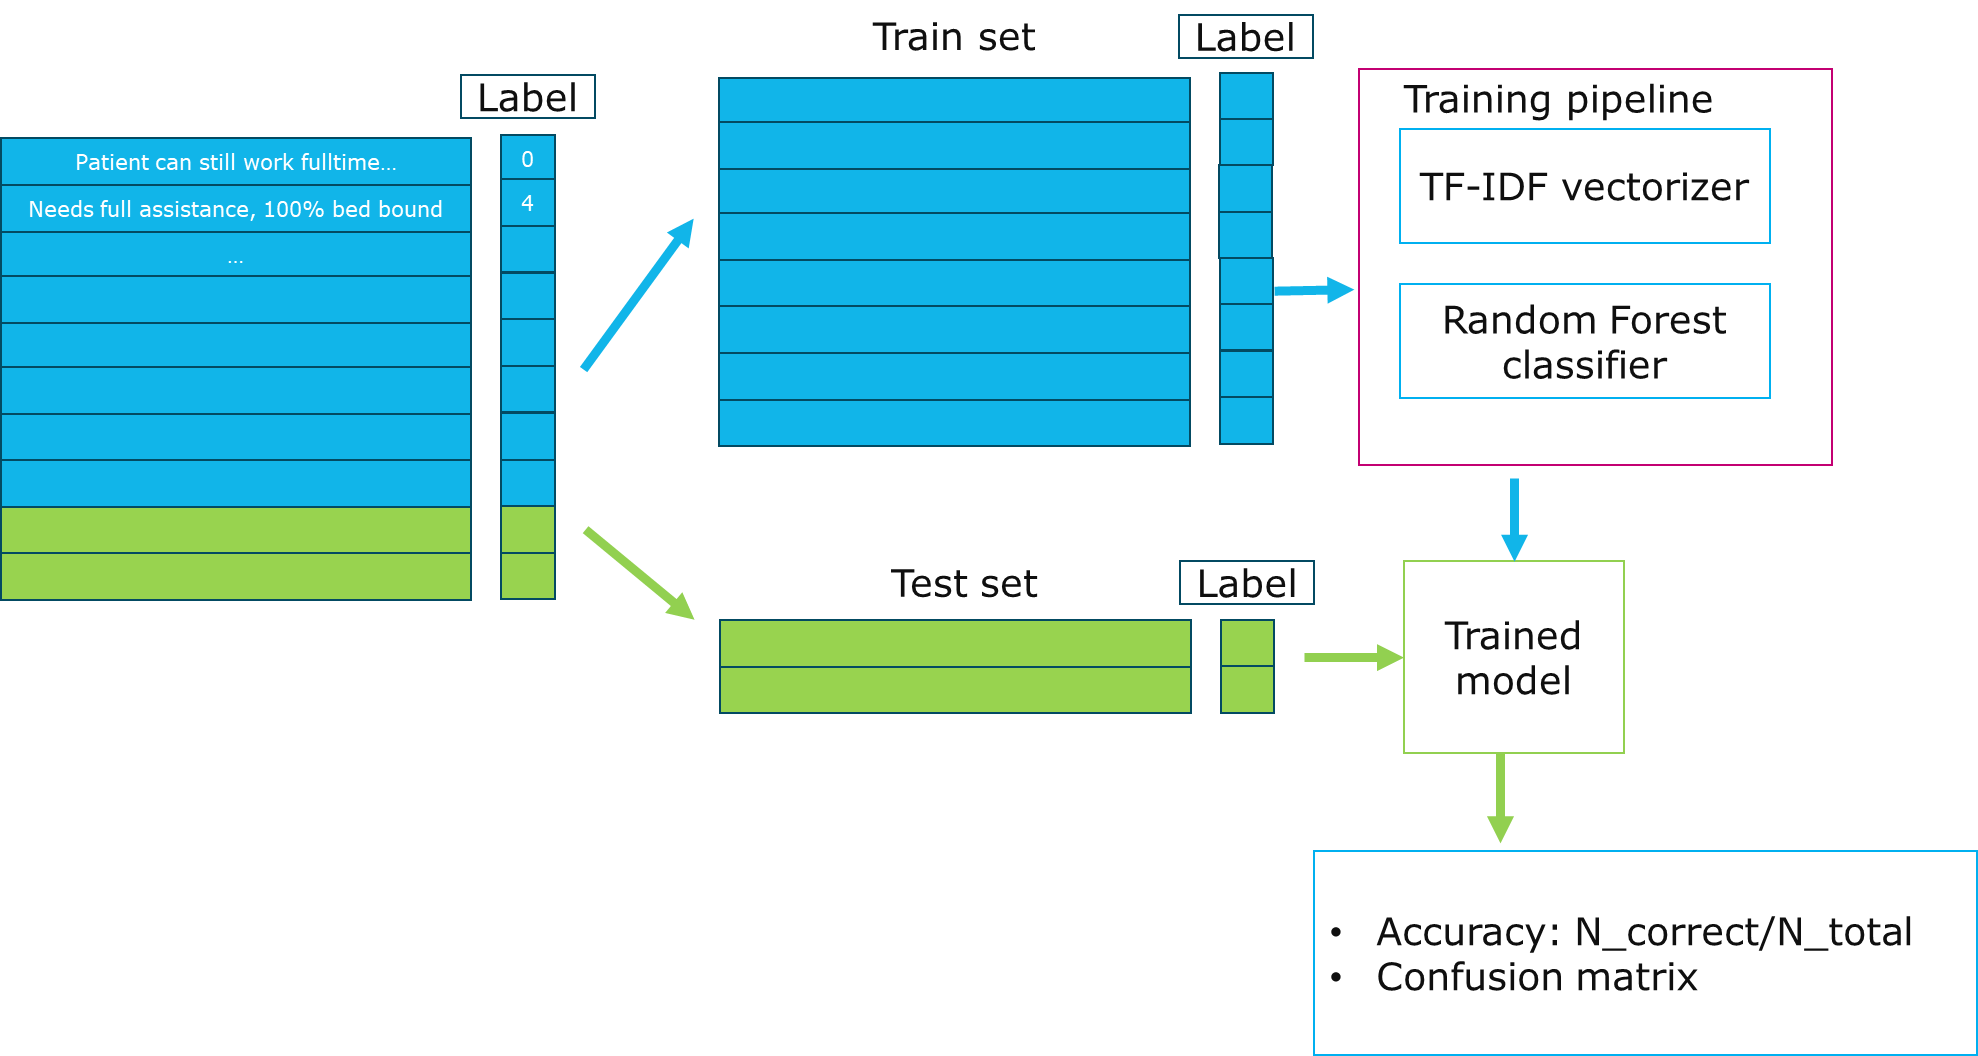

In [3]:
#Load packages and install dependecies

#Load models needed for later
load_models()

#Load synthetic data
df=load_data()


#Divide set into training and test set
df_train, df_test, y_train, y_test = train_test_split(df['text'], df['ps_label'], stratify=df['ps_label'], test_size=0.2, random_state=9)

print("The number of documents in the dataset is: " + str(len(df)))
print("The number of documents in the training set is: " + str(len(df_train)))
print("The number of documents in the test set is: " + str(len(df_test)))

--2025-10-31 16:54:40--  https://github.com/IKNL/iacr_2025_llm_workshop/raw/refs/heads/main/model/Model_IACR_rs9.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/IKNL/iacr_2025_llm_workshop/refs/heads/main/model/Model_IACR_rs9.zip [following]
--2025-10-31 16:54:40--  https://media.githubusercontent.com/media/IKNL/iacr_2025_llm_workshop/refs/heads/main/model/Model_IACR_rs9.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405274404 (386M) [application/zip]
Saving to: ‘Model_IACR_rs9.zip’

Model_IACR_rs9.zip   99%[==================> ] 385.85M  1.03MB/s    in 4m 51s  

2025-10

In [4]:
##This is the content of the complete dataset:

df[['text','ps_label','PS Text Snippet']].head(10)

,text,ps_label,PS Text Snippet
0,This is a 81-year-old non-binary with mesothel...,3,requires daily caregiver support for transfers...
1,"31-year-old female with Colorectal carcinoma, ...",2,Requires some assistance for housework and out...
2,A 33-year-old female diagnosed with gastric ca...,3,The patient is mostly bedridden or chairbound ...
3,This 31-year-old non-binary presents with Test...,3,The patient confined to bed or chair for more ...
4,This 81-year-old female with a history of Hepa...,4,"Completely bedbound, fully dependent on contin..."
5,"68-year-old female with Renal cell carcinoma, ...",2,Capable of self-care but spends much of the da...
6,The patient is a 68-year-old female diagnosed ...,3,Can manage brief communication and feeding but...
7,The patient is a 80-year-old female diagnosed ...,2,Spends a significant portion of the day restin...
8,The patient is a 31-year-old female diagnosed ...,0,"fully active, works full-time, exercises, inde..."
9,51-year-old female with a history of Gastric c...,5,Patient passed away; case closed


Machine learning models cannot work directly with raw texts, but they require a numerical matrix, where each row corresponds to one document, and each column correspond to a feature/covariate (number that describes a characteristics of the text). The features could simply be a 1 if a certain word is present and a 0 if the word is not present. This would make the vector for each document as long as the number of words in the vocaboulary, which is too long.

<br>

**How can we transform texts into meaningful numerical vectors, but keeping the lenght compact enough?**

<br>

In this workshop we will explore:



*   TF-IDF
*  Embeddings


<br>
<br>

This is an example of vectorization with TF-IDF, see also next Module:

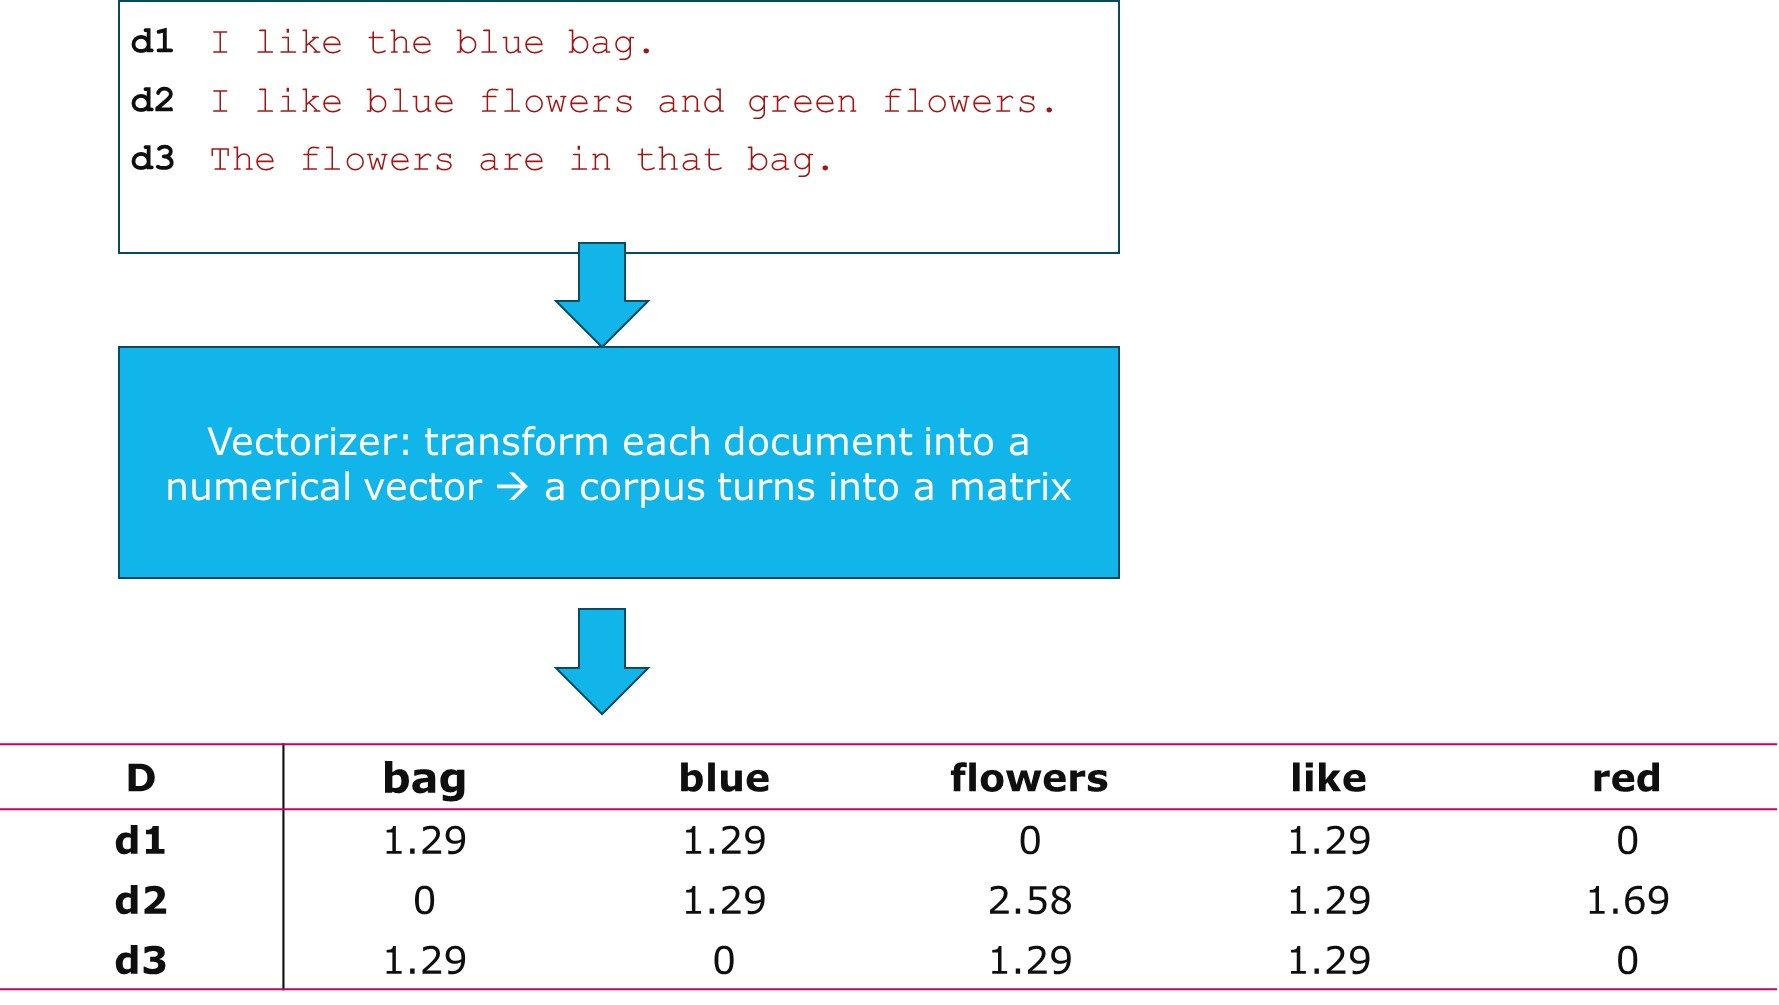

# **Module 1: TF-IDF Classification**


TF-IDF (Term Frequency–Inverse Document Frequency)is a statistical method used in natural language processing and information retrieval to evaluate how important a word is to a document in relation to a larger collection of documents. TF-IDF combines two components:

**Term Frequency (TF)**: Measures how often a word appears in a document. A higher frequency suggests greater importance. If a term appears frequently in a document, it is likely relevant to the document’s content. The formula is <br>
$TF(t,d) = f_{d,t}$ <br>
Here $f_{t,d}$ represents the number of times the term t appears in document d.

<br>

**Inverse Document Frequency (IDF)**: Reduces the weight of common words across multiple documents while increasing the weight of rare words. If a term appears in fewer documents, it is more likely to be meaningful and specific. The formula is:<br>
$IDF(t) = log \frac{N +1}{DF(t) + 1} + 1$,<br>

where N is the total number of documents and DF(t) is the number of documents containing the term t.

<br>

Finally, TF-IDF is calculated as:

$TFIDF(t, d) = TF(t,d) * IDF(t)$



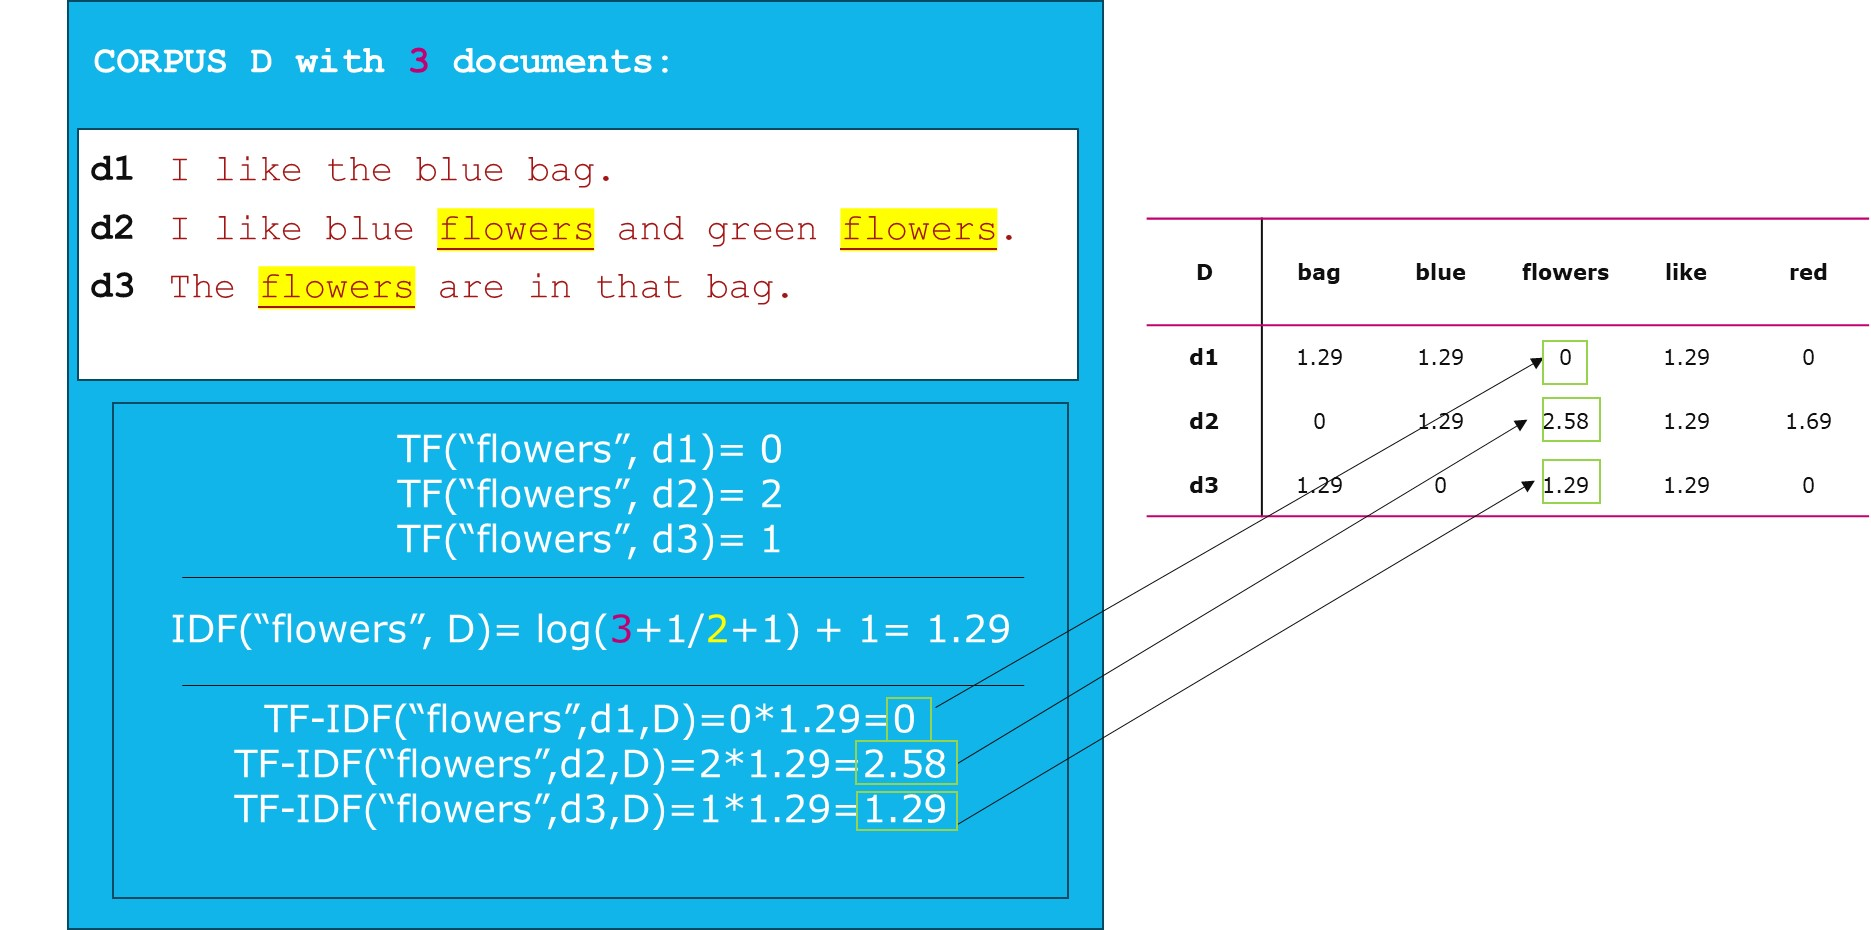

This balance allows TF-IDF to highlight terms that are both frequent within a specific document and distinctive across the text document, making it a useful tool for tasks like search ranking, text classification and keyword extraction.

<br>

A key advantage of TF-IDF is that it balances out the term frequency (how often a word appears in a document) and its inverse document frequency (how rare or common a word is in the entire corpus).

-----
We are now going to:


1.  Create a TF-IDF representation based on the training set vocaboulary
2.  Represent each note based on the TF-IDF representation
3. Train a classifier on the training set (Random Forest, but can be any classifier)
4. Evaluate performance on test set (confusion matrix and accuracy)


<br>
<br>
<br>

In [5]:
# ------------------------------
# Module 1: TF-IDF Classification
# ------------------------------


#Instantiate TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english',
                        min_df=0.05) #avoid inclusion of very rare words


#Fit TF-IDF vectorizer on our training set
X_train = tfidf.fit_transform(df_train.values)

print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of unique words: {len(tfidf.get_feature_names_out())}")

Feature matrix shape: (219, 421)
Number of unique words: 421


In [6]:
print(pd.DataFrame(data=X_train.toarray(), columns=tfidf.get_feature_names_out()))

      10        11        12        13   14       240   32   67  able  \
0    0.0  0.000000  0.177271  0.000000  0.0  0.000000  0.0  0.0   0.0   
1    0.0  0.000000  0.000000  0.169431  0.0  0.000000  0.0  0.0   0.0   
2    0.0  0.000000  0.186750  0.000000  0.0  0.000000  0.0  0.0   0.0   
3    0.0  0.000000  0.114176  0.000000  0.0  0.144065  0.0  0.0   0.0   
4    0.0  0.000000  0.112832  0.000000  0.0  0.142369  0.0  0.0   0.0   
..   ...       ...       ...       ...  ...       ...  ...  ...   ...   
214  0.0  0.170248  0.000000  0.000000  0.0  0.000000  0.0  0.0   0.0   
215  0.0  0.256247  0.000000  0.000000  0.0  0.000000  0.0  0.0   0.0   
216  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.0   0.0   
217  0.0  0.000000  0.103081  0.000000  0.0  0.130065  0.0  0.0   0.0   
218  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.0   0.0   

     acceptable  ...       wbc    weekly     weeks    weight      work  \
0      0.000000  ...  0.102344  0.000000  0.08689

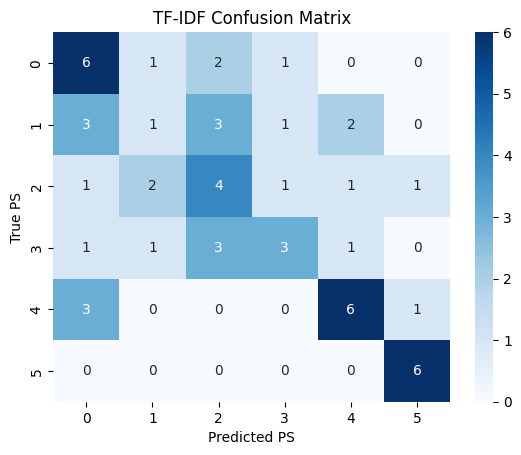

Accuracy is: 0.4727272727272727


In [7]:
#Train model
clf_tfidf = RandomForestClassifier(random_state=1)
clf_tfidf.fit(X_train, y_train)

#Predict test dataset
y_pred_tfidf = predict_tfidf(df_test)

# Confusion Matrix, accuracy and RMSE

accuracy_tfidf=measure_performance(y_test, y_pred_tfidf)



Let's have a look at the feature importance of this model. To know more about the feature importance in random forest classifiers, you can have a look at: https://www.geeksforgeeks.org/machine-learning/feature-importance-with-random-forests/

In [8]:
# Get feature importances from the trained model
feature_importances = clf_tfidf.feature_importances_

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Create a pandas Series to easily sort feature importances
importance_series = pd.Series(feature_importances, index=feature_names)

# Sort the features by importance in descending order
sorted_importance = importance_series.sort_values(ascending=False)

# Print the top 10 most important features
print("Top 10 most important features:")
print(sorted_importance.head(10))

Top 10 most important features:
completely    0.016562
limitation    0.015434
grade         0.013970
nursing       0.013012
help          0.012905
self          0.012321
dependent     0.011637
old           0.011176
year          0.010920
ctcae         0.010700
dtype: float64


# Discussion:

Can you think of any possible limitation with this simple method?

<br>

<br>

<br>

<br>

<br>

<br>

-------------








Main limitations:

* Lack of Context Understanding: TF-IDF does not capture the semantic meaning or context of words. For example, it treats synonyms as completely different terms and cannot understand polysemy (words with multiple meanings).

* High Dimensionality: The feature space can become extremely large, especially for large corpora, as each unique word becomes a feature. This can lead to computational inefficiency and challenges in model training.

* Sensitivity to Rare Words: While TF-IDF gives higher importance to rare words, it may overemphasize terms that are rare but not necessarily meaningful or relevant to the task.


* Static Weighting: The weights assigned by TF-IDF are static and do not adapt based on the task or context, which can limit its effectiveness in dynamic or domain-specific applications.

* Inability to Handle Out-of-Vocabulary Words: TF-IDF cannot process words that were not present in the training corpus, making it less robust for unseen data.

* No Consideration of Word Order: It treats documents as "bags of words," ignoring the order of words, which can be crucial for understanding the meaning of text.

* Sparse Representation: The resulting matrix is often sparse, which can lead to inefficiencies in storage and computation.

* Not Effective for Short Texts: In cases like tweets or short messages, TF-IDF may not perform well due to insufficient term frequency data.

Therefore, we could look into transformer-based dynamic embeddings.

# **Module 2: Dynamic embeddings**



## 2.1 What Are Embeddings?

Computers don’t understand words — they understand numbers.  
**Embeddings** represent words or sentences into numerical vectors that reflect meaning. Semantically similar sentences are closer together in the embedding space, while dissimilar sentences are pushed apart.

| Text | Simplified Vector |
|------|------------------|
| “walks independently” | (0.9, 0.1) |
| “fully active” | (0.8, 0.2) |
| “bedbound” | (-0.7, -0.9) |

- “walks independently” and “fully active” are *close together* → similar meaning.  
- “bedbound” is far away → very different meaning.

Embeddings help NLP systems **understand context and synonyms**, not just count words. We are goint to extract embeddings coming from pre-trained LLMs, which are neural networks trained on tons of text, e.g. newspapers, wikipedia, social networks etc. These models are trained to learn to represent the meaning of the text, and sometimes they are trained to embed the similarity between sentences/paragraphs (**sentence transformers**).






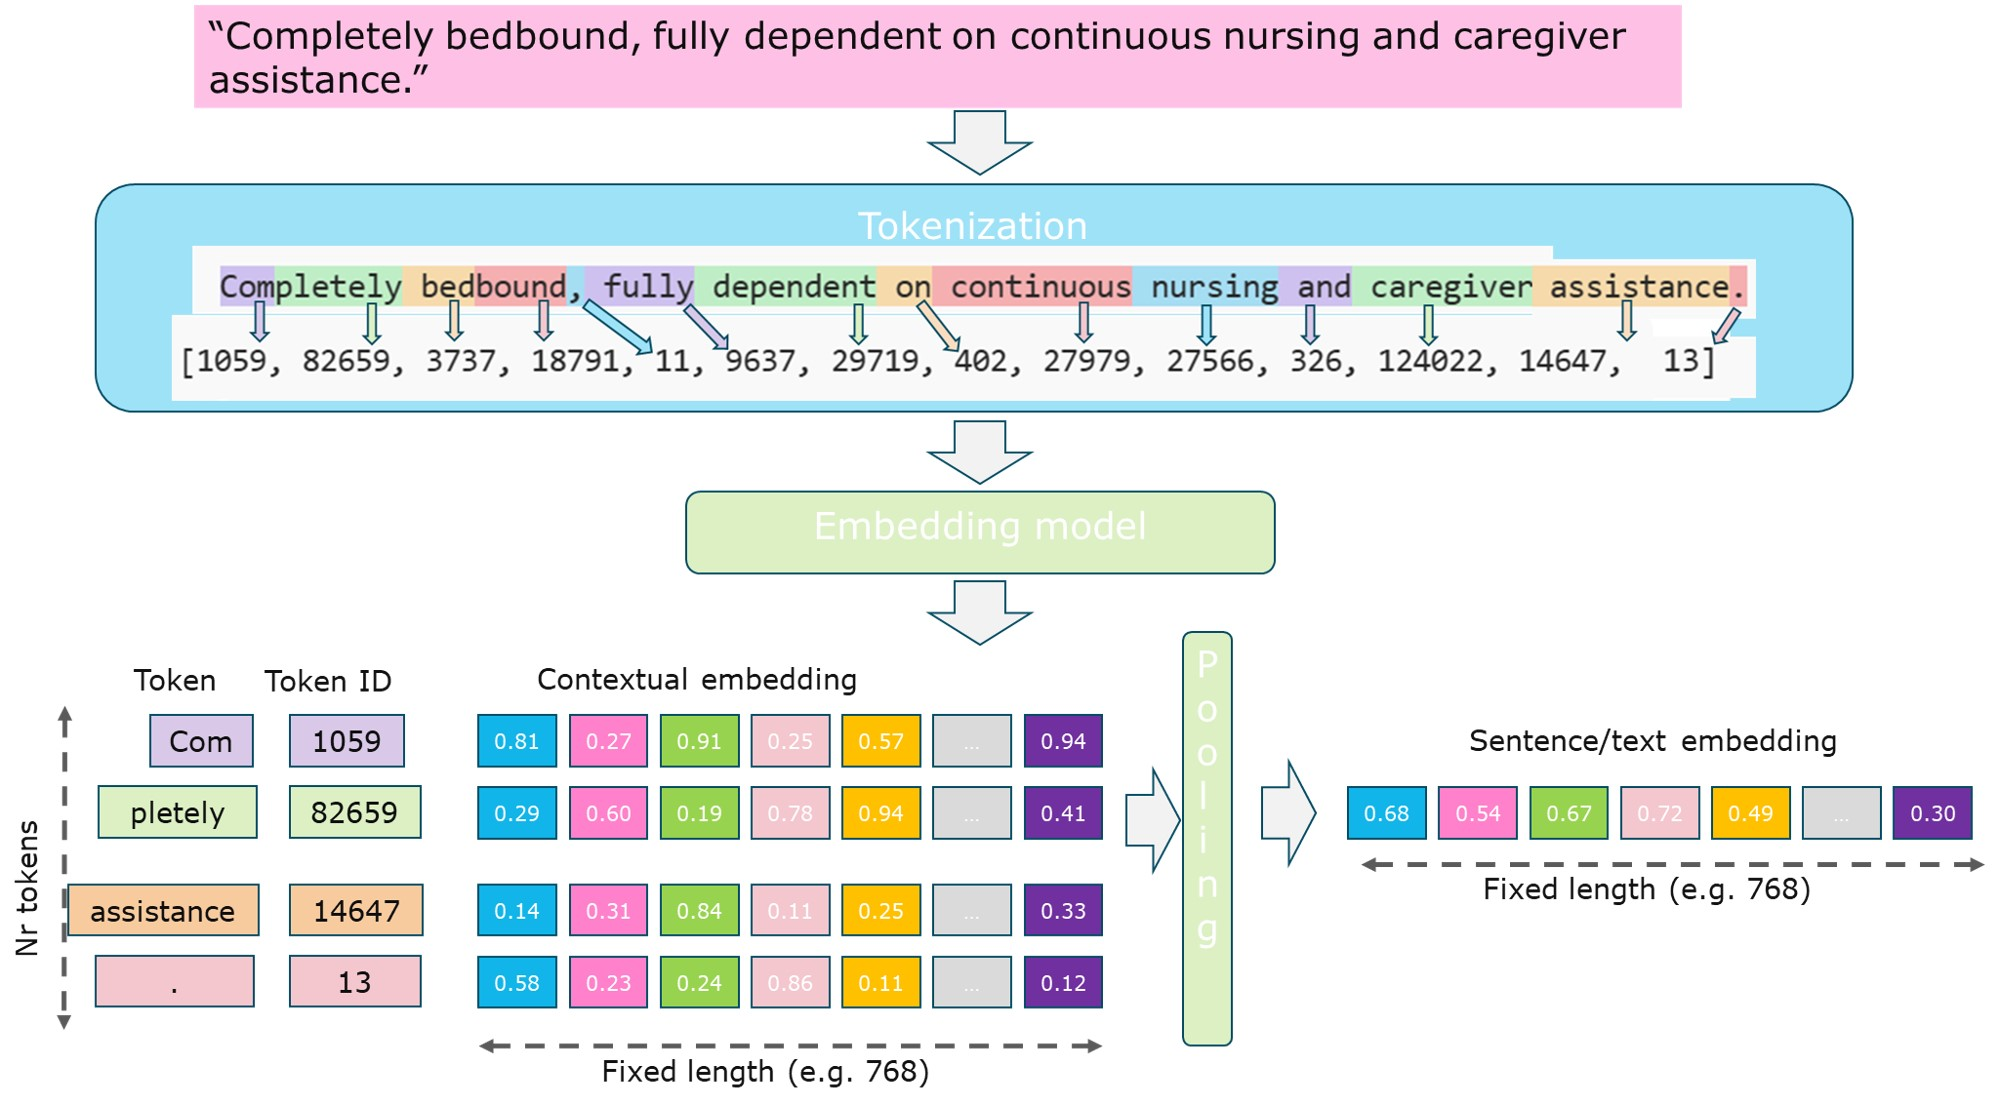

If you want to see how tokenizer works, have a look at: https://platform.openai.com/tokenizer Another useful resource for embeddings and tokenizaton: https://medium.com/@saschametzger/what-are-tokens-vectors-and-embeddings-how-do-you-create-them-e2a3e698e037



---

## 2.3 Which embedding model are we going to use?
paraphrase-mpnet-base-v2 is a sentence-transformers model: it maps sentences & paragraphs to a 768 dimensional dense vector space. A sentence transformers is very good in creating good embeddings of entire sentences or paragraphs, which is indicated for classifiying text.

In [9]:
# ------------------------------
# Module 2: Sentence Embeddings + Classifier
# ------------------------------

#Load pre-trained model
embed_model = sentence_transformers.SentenceTransformer("sentence-transformers/paraphrase-mpnet-base-v2") #'all-mpnet-base-v2')#('all-MiniLM-L6-v2')

#Extract embeddings for training set
X_embed = embed_model.encode(df_train.values)




modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
print('The shape of the embeddings matrix is: ' + str(X_embed.shape))
print(pd.DataFrame(data=X_embed))

The shape of the embeddings matrix is: (219, 768)
          0         1         2         3         4         5         6    \
0   -0.080843  0.111735 -0.101231 -0.129625 -0.118823  0.147240  0.068646   
1   -0.019041  0.058952 -0.024044 -0.159191 -0.086540  0.194822 -0.107235   
2   -0.077755  0.242952  0.039300 -0.014100 -0.023900  0.135717 -0.034469   
3   -0.108279  0.116338  0.020050 -0.051973 -0.079978  0.058776  0.057681   
4   -0.092675  0.072172 -0.003889 -0.096694 -0.050667  0.061660 -0.029785   
..        ...       ...       ...       ...       ...       ...       ...   
214 -0.045583  0.043694 -0.043550 -0.129633 -0.041984  0.150935  0.034625   
215 -0.008285  0.088854  0.007551 -0.022409 -0.198219  0.141361  0.000450   
216  0.028695  0.125726 -0.068817 -0.179463 -0.124197  0.133152  0.089815   
217 -0.052699  0.154471 -0.004813 -0.002821 -0.112420  0.085816  0.055098   
218 -0.015939  0.123149 -0.030127 -0.071082 -0.066373  0.120233  0.063129   

          7         8    

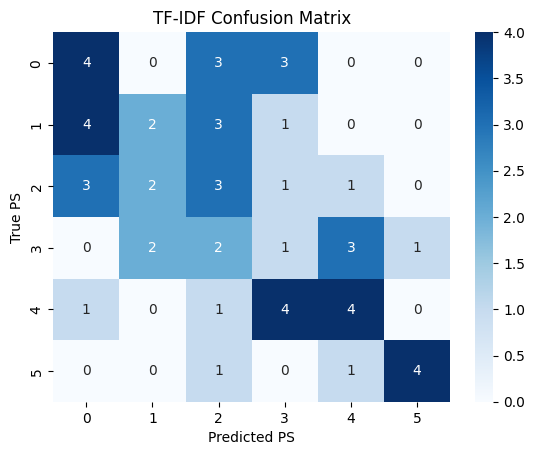

Accuracy is: 0.32727272727272727


In [11]:
#Train model
clf_embed =  RandomForestClassifier(random_state=1) #LogisticRegression(max_iter=1000)
clf_embed.fit(X_embed, y_train)

#Evaluate on test dataset
y_pred_embed = predict_sent_embed(df_test.values)

# Confusion Matrix, accuracy and RMSE
accuracy_embed=measure_performance(y_test, y_pred_embed)

# Discussion:

Embeddings capture semantic similarity better than TF-IDF.

Why is it different for this specific dataset? What could be the issue?

# **Module 3. Finetuning with few examples: SETFIT**

A pre-trained model is an AI model that has already been trained on a very large dataset to learn general patterns in language before you use it for your own task.
After this pretraining, the model:



*   Understands grammar and syntax

* Knows word meanings and context

* Can represent sentences as vectors capturing their semantics

**Finetuning** means taking that pre-trained model and continuing training it on a smaller, task-specific dataset — so it specializes in your problem. Weight of the model are updated during this process. When finetuning is performed with few examples from the training set, this is called **few-shot** learning.

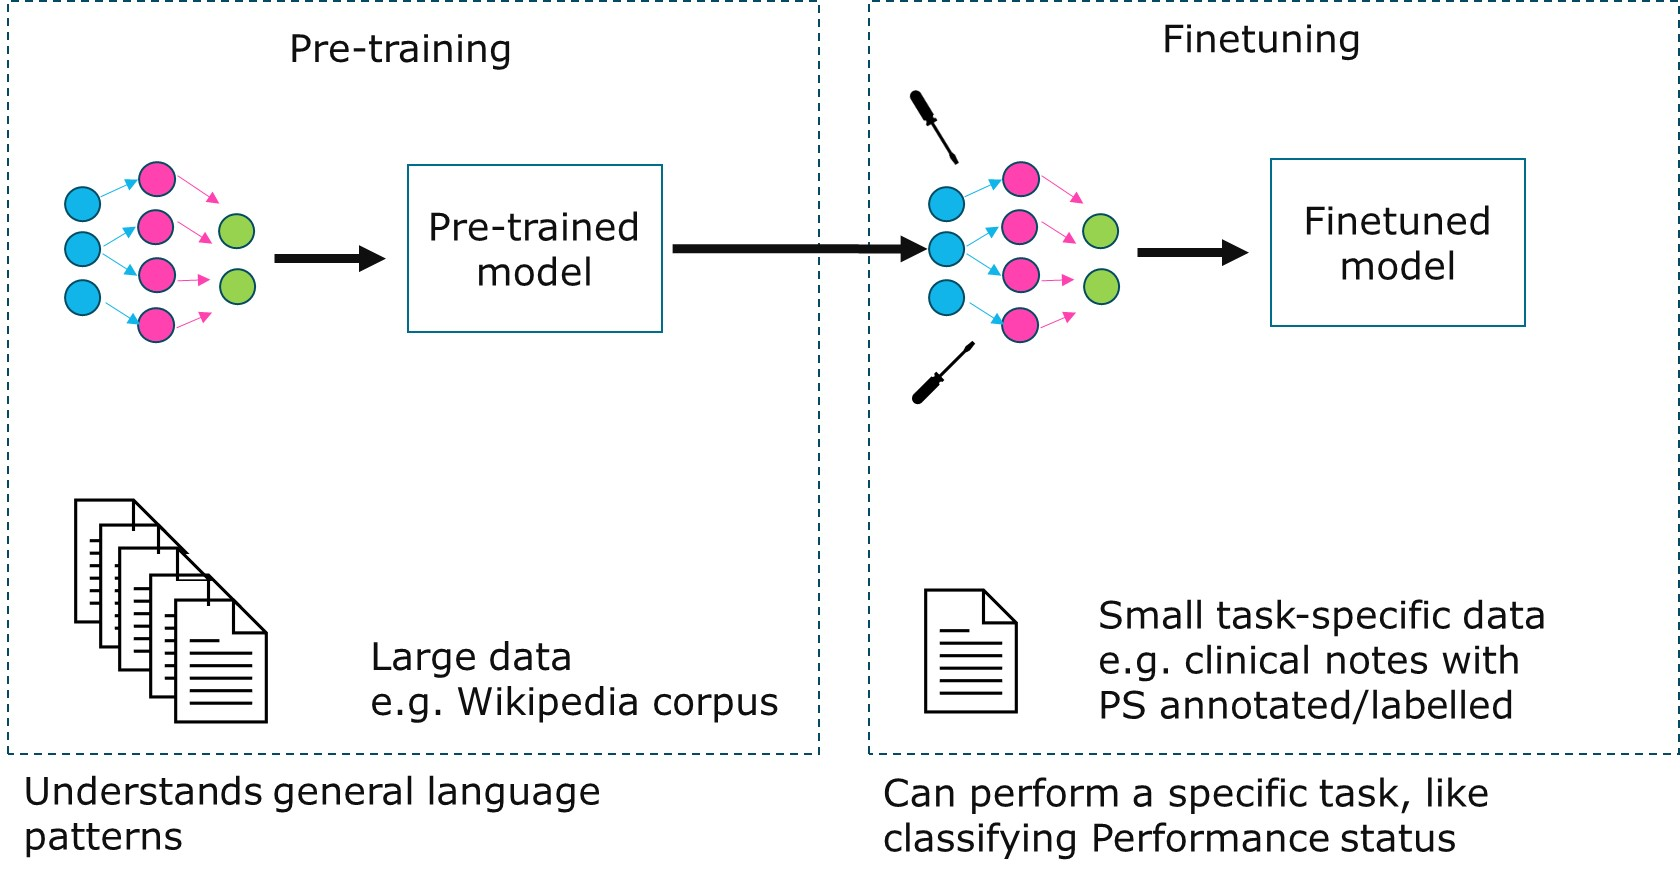

Source: https://www.theriseunion.com/en/blog/Understanding-the-essential-Role-of-RAG-Fine-tuning-and-LoRA-in-GenAI.html

## 3.1 Few-shot and SetFit

SetFit is an efficient and prompt-free framework for few-shot finetuning of Sentence Transformers. Few-shot means that it requres only few (e.g. 8-16) examples to work.
It is fast to train and supports multilingual texts.

<br>

Setfit starts with a pre-trained Sentence Transformer, which already knows how to represent sentence meanings. Instead of updating completely the model, it was updates the embedding representation, by making the documents representation closer in the embedding space if they belong to the same class, and more distant if they belong to different class (**contrastive learning**).

<br>

Last step is to train a small classifier on the tuned embeddings to predict labels, similar to what we did earlier. The difference is that this time Setfit takes care of this step under the hood, so we do not need to train explicitely the random forest classifier.


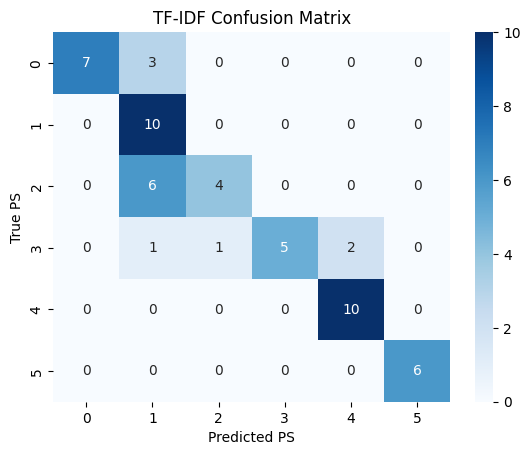

Accuracy is: 0.7636363636363637


In [12]:
##Comparison with setfit

#Load model- offline finetuned model, based on same mpnet model showed earlier in module 2
model = SetFitModel.from_pretrained("/content/Model_IACR_rs9",local_files_only=True) # Load from a local directory

#Predict test dataset
test_dataset = Dataset.from_pandas(df.loc[df_test.index,['text','ps_label']])
setfit_pred=model.predict(test_dataset)

#Confusion matrix, accuracy and RMSE
accuracy_few_shot=measure_performance(y_test, setfit_pred)


Results improved a lot with only 6 examples labelled!

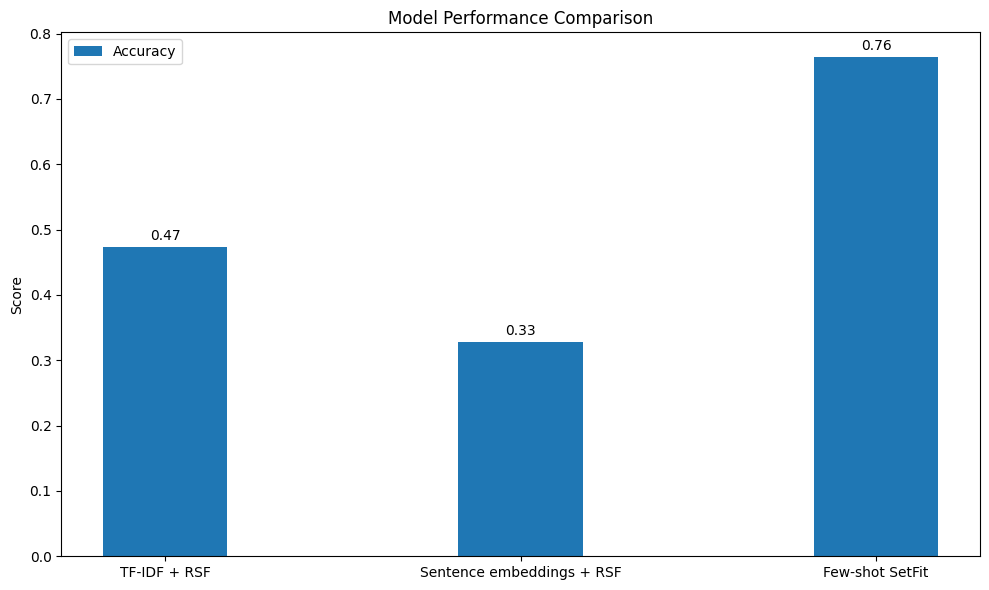

In [13]:
models = ['TF-IDF + RSF', 'Sentence embeddings + RSF', 'Few-shot SetFit']
accuracy_scores = [accuracy_tfidf, accuracy_embed, accuracy_few_shot]

print_accuracies(models,accuracy_scores)



# **Module 4. Prompt-based zero-shot classification**

We might not always have **annotated** medical notes, meaning that PS might not be known for each document and the process of manually annotating might be extensive.
In this case, another option is to classify notes based on zero-shot learning. In zero-shot learning, no examples from the training set are needed and the model is not updated.

<br>

Zero-shot classification can be performed in combination with **prompt engineering** and **generative models**, which can produce text in response, while previous models were embedding models and did not generate text but only embeddings. Prompt engineering is the process of designing and optimizing prompts to effectively interact with pre-trained models. It's what you do when you ask something to ChatGPT.

<br>

In this case, we ask the trained LLM to generate the PS score given a certain text, we explain which candidate labels the model can choose from and it is also possible to add some extra context and explanation. This all together makes the prompt.

<br>

In this example, as Performance Status is a clinical score, we would like to give some more context. In that case we can use some descriptions of each label, but we are not showing any real examples from the training set. No manual annotation is needed and we can tweak the examples and what we would like to get just in the prompt, making it more accessible to people with less experience in coding.







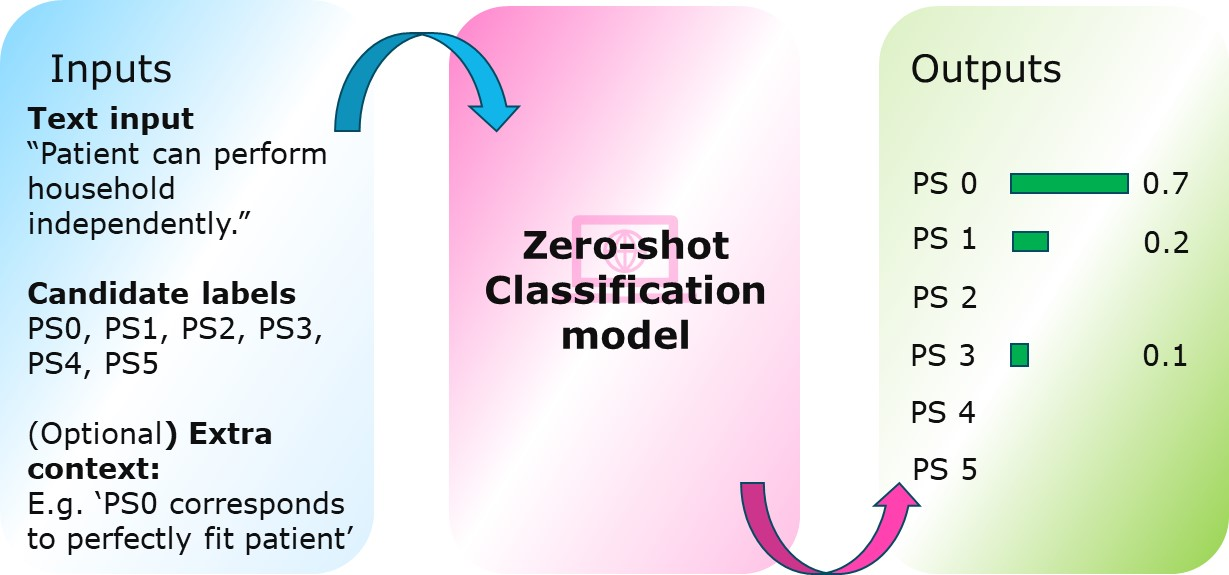

Source: https://huggingface.co/tasks/zero-shot-classification

In [14]:
# ------------------------------
# Module 4: Zero-shot Classification
# ------------------------------

zero_shot = transformers.pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
candidate_labels = ["0","1","2","3","4","5"]


# Zero-shot prompt context
Context = [
    "Patient walks independently, manages all daily activities. -> 0",
    "Patient has to rest sometimes, but can keep doing the daily activities. -> 1",
    "Needs help with dressing and bathing, mostly active at home. -> 2",
    "Patient has to sit or lie on bed almost all day. -> 3",
    "Bedridden, completely dependent for care. -> 4",
    "Patient is deceased. -> 5",
]



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [15]:
# Demo prediction
new_sentence = "Patient can still work as usual. He came on foot to the hospital." #"Able to perform light chores but tires easily."
#new_sentence = "Able to perform light chores but tires easily."

prompt_text = "\n".join(Context) + "\n" + new_sentence + " ->"

print("This is the prompt:")
print(prompt_text)
print('')
print("These are the candidate labels: " + str(candidate_labels))
print('')


label, score = predict_zero_shot(new_sentence)
print("This is the zero-shot prediction: ")
print("Predicted PS:", label, f"(score: {score:.2f})")


This is the prompt:
Patient walks independently, manages all daily activities. -> 0
Patient has to rest sometimes, but can keep doing the daily activities. -> 1
Needs help with dressing and bathing, mostly active at home. -> 2
Patient has to sit or lie on bed almost all day. -> 3
Bedridden, completely dependent for care. -> 4
Patient is deceased. -> 5
Patient can still work as usual. He came on foot to the hospital. ->

These are the candidate labels: ['0', '1', '2', '3', '4', '5']

This is the zero-shot prediction: 
Predicted PS: 0 (score: 0.21)


Main pro and con:

*   Works when annotations are not really possible to get
*   Less coding required
*   May fail with rare or domain-specific language





# **Module 4. Comparison with our own sentences**

In [16]:
#Try your sentence
sentence='Patient needs assistance for selfcare and household.' #'Patient can still work full time'

test_sentence(sentence)

The predicted PS for the TF-IDF classifier is:5
The predicted PS for the sentence embeddings classifier is:3
The predicted PS for the setfit few shot classifier is:4
The predicted PS for the prompt-based zero shot classifier is:1
